# 📄 Raport Techniczny: Etap 1 - Przetwarzanie Obrazu i Segmentacja

**Autor:** Osoba 1
**Cel:** Przygotowanie surowych danych (obrazów mikroskopowych) do dalszej analizy poprzez ekstrakcję pojedynczych krwinek i stworzenie ich masek binarnych.

**Zakres prac:**
1.  **Ekstrakcja danych:** Wycięcie pojedynczych komórek na podstawie adnotacji COCO (BCCD Dataset).
2.  **Preprocessing:** Normalizacja rozmiaru, filtracja szumów.
3.  **Segmentacja:** Automatyczne wydzielenie obiektów z tła przy użyciu algorytmu K-Means.
4.  **Post-processing:** Operacje morfologiczne w celu wygładzenia masek.

#### Importy i ustawienie ścieżek

In [2]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import kagglehub

# Pobieramy aktualną ścieżkę (Pulpit/BloodCells)
BASE_DIR = os.getcwd()

# Definiujemy ścieżki względne do danych
# Folder BCCD(COCO) wewnątrz BloodCells:
DATA_DIR = os.path.join(BASE_DIR, 'BCCD(COCO)', 'train')
JSON_PATH = os.path.join(DATA_DIR, '_annotations.coco.json')

print(f"Ścieżka projektu: {BASE_DIR}")

Ścieżka projektu: C:\Users\User IKEA\Desktop\BloodCells


#### Pobieranie i wczytywanie adnotacji

In [3]:
# Wczytanie JSON
with open(JSON_PATH, 'r') as f:
    coco_data = json.load(f)

print("Klucze zbioru:", coco_data.keys())
print("Kategorie:", coco_data['categories'])

Klucze zbioru: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Kategorie: [{'id': 0, 'name': 'cells', 'supercategory': 'none'}, {'id': 1, 'name': 'Platelets', 'supercategory': 'cells'}, {'id': 2, 'name': 'RBC', 'supercategory': 'cells'}, {'id': 3, 'name': 'WBC', 'supercategory': 'cells'}]


#### /// Wycięcie i wyświetlenie testowej komórki

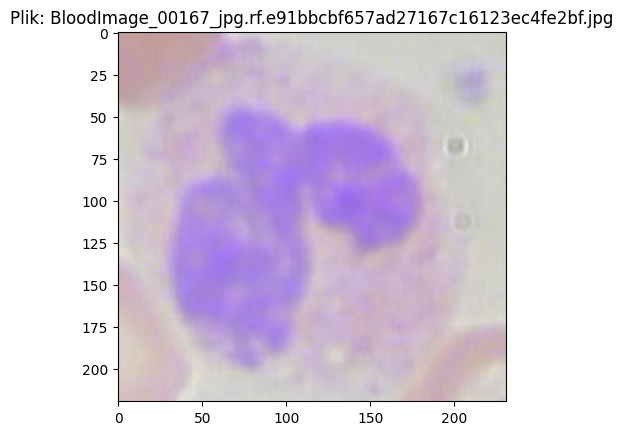

In [4]:
# 1. Znajdźmy pierwszą adnotację dla WBC (Białej Krwinki)
for adnotacja in coco_data['annotations']:
    if adnotacja['category_id'] == 3:
        nasza_krwinka = adnotacja
        break # Znaleźliśmy pierwszą, więc kończymy szukanie

# 2. Wyciągnijmy ID zdjęcia i współrzędne ramki (bbox)
id_zdjecia = nasza_krwinka['image_id']
x, y, szerokosc, wysokosc = nasza_krwinka['bbox']

# 3. Znajdźmy nazwę pliku dla tego ID zdjęcia
for zdjecie in coco_data['images']:
    if zdjecie['id'] == id_zdjecia:
        nazwa_pliku = zdjecie['file_name']
        break

# 4. Zbudujmy ścieżkę i wczytajmy obraz
pelna_sciezka = os.path.join(DATA_DIR, nazwa_pliku)
obraz = cv2.imread(pelna_sciezka)

# 5. Wytnijmy krwinkę i przygotujmy do wyświetlenia
if obraz is not None:
    # Wycinanie: obraz[ od_góry : do_dołu , od_lewej : do_prawej ]
    wycinek = obraz[int(y) : int(y + wysokosc), int(x) : int(x + szerokosc)]

    # Zamiana kolorów z BGR na RGB (żeby nie była niebieska)
    wycinek_rgb = cv2.cvtColor(wycinek, cv2.COLOR_BGR2RGB)

    plt.imshow(wycinek_rgb)
    plt.title(f"Plik: {nazwa_pliku}")
    plt.show()

#### Wycięcie wszystkich krwinek na podstawie Bounding Boxów

##### Przygotowanie folderów

In [6]:
# Stworzenie folderu na wycięte krwinki
output_dir = os.path.join(BASE_DIR, 'output')

# Słownik, który mapuje ID kategorii na nazwy
kategorie_mapa = {
    1: 'Platelets',
    2: 'RBC',
    3: 'WBC'
}

# Tworzymy foldery, jeśli jeszcze nie istnieją
for nazwa in kategorie_mapa.values():
    os.makedirs(os.path.join(output_dir, nazwa), exist_ok=True)

print("Struktura folderów gotowa w:", output_dir)

Struktura folderów gotowa w: C:\Users\User IKEA\Desktop\BloodCells\output


##### Wycięcie

In [11]:
# Zerujemy licznik przed startem pętli
licznik = 0

for ann in coco_data['annotations']:
    cat_id = ann['category_id']

    # Sprawdzamy, czy kategoria nas interesuje (RBC, WBC, Platelets)
    if cat_id not in kategorie_mapa:
        continue

    nazwa_kat = kategorie_mapa[cat_id]

    # --- KROK 1: SZUKANIE NAZWY PLIKU ---
    nazwa_pliku = ""
    for zdjecie in coco_data['images']:
        if zdjecie['id'] == ann['image_id']:
            nazwa_pliku = zdjecie['file_name']
            break

    # --- KROK 2: WCZYTANIE I WYCIĘCIE ---
    sciezka_do_obrazu = os.path.join(DATA_DIR, nazwa_pliku)
    obraz = cv2.imread(sciezka_do_obrazu)

    if obraz is not None:
        # Wyciągamy współrzędne ramki
        x, y, w, h = ann['bbox']

        # Wycinamy krwinkę
        wycinek = obraz[int(y):int(y+h), int(x):int(x+w)]

        # --- KROK 3: ZABEZPIECZENIE I ZAPIS ---
        if wycinek is not None and wycinek.size > 0:

            # --- NOWOŚĆ: ZMIANA ROZMIARU NA 128x128 ---
            # To jest kluczowe dla Osoby 2 i 3!
            wycinek_resized = cv2.resize(wycinek, (128, 128))

            # Tworzymy ścieżkę zapisu
            sciezka_zapisu = os.path.join(output_dir, nazwa_kat, f"crop_{licznik}.jpg")

            # Zapisujemy przeskalowany obraz
            cv2.imwrite(sciezka_zapisu, wycinek_resized)

            # Zwiększamy licznik o 1 tylko po udanym zapisie
            licznik += 1
        else:
            print(f"Pominięto pusty wycinek na zdjęciu: {nazwa_pliku}")
    else:
        # To się wyświetli tylko, jeśli Python nie znajdzie pliku na dysku
        print(f"Nie udało się wczytać obrazu: {nazwa_pliku}")

print(f"Sukces! Wycięto, przeskalowano (128x128) i zapisano {licznik} krwinek.")

Pominięto pusty wycinek na zdjęciu: BloodImage_00343_jpg.rf.307a02c2f64a99bb49154ce548c5d4a1.jpg
Pominięto pusty wycinek na zdjęciu: BloodImage_00338_jpg.rf.c0f0d2cd5a51f7fff518cef688e274af.jpg
Sukces! Wycięto, przeskalowano (128x128) i zapisano 3448 krwinek.


In [7]:
# Słownik na wyniki
statystyki = {}

for kategoria in ['Platelets', 'RBC', 'WBC']:
    sciezka_folderu = os.path.join(output_dir, kategoria)

    # Listujemy pliki i sprawdzamy ile ich jest
    pliki = [f for f in os.listdir(sciezka_folderu) if os.path.isfile(os.path.join(sciezka_folderu, f))]
    statystyki[kategoria] = len(pliki)

# Wyświetlamy wyniki
print(f"📊 STATYSTYKI ZBIORU:")
print(f"----------------------")
print(f"Platelets: {statystyki['Platelets']}")
print(f"RBC:       {statystyki['RBC']}")
print(f"WBC:       {statystyki['WBC']}")
print(f"----------------------")
print(f"Suma wszystkich wycinków: {sum(statystyki.values())}")

📊 STATYSTYKI ZBIORU:
----------------------
Platelets: 249
RBC:       2936
WBC:       263
----------------------
Suma wszystkich wycinków: 3448


#### /// Filtracja - testy

Szukam pliku tutaj: C:\Users\User IKEA\Desktop\BloodCells\output\WBC\crop_14.jpg


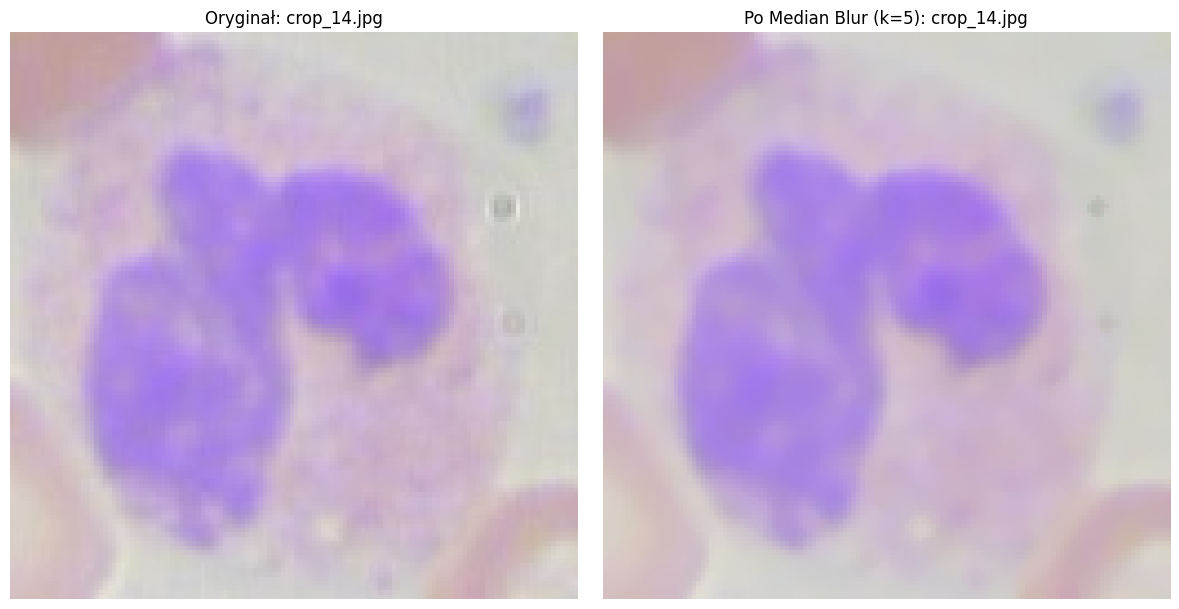

In [8]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt

TEST_FOLDER = os.path.join(BASE_DIR, 'output', 'WBC')
TEST_IMAGE = "crop_14.jpg"
full_path = os.path.join(TEST_FOLDER, TEST_IMAGE)

print(f'Szukam pliku tutaj: {full_path}')

#Wczytanie obrazu format BGR
img = cv.imread(full_path)

if img is None:
    print("Nie znaleziono obrazu!")
else:
    # 2. Obróbka (Median Blur na BGR)
    denoised_img = cv.medianBlur(img, 5)

    # 3. Konwersja obu obrazów na RGB do wyświetlenia
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    denoised_rgb = cv.cvtColor(denoised_img, cv.COLOR_BGR2RGB)

    # 4. Wyświetlanie obok siebie
    plt.figure(figsize=(12, 6))

    # Lewa strona: Oryginał
    plt.subplot(1, 2, 1)
    plt.title(f"Oryginał: {TEST_IMAGE}")
    plt.imshow(img_rgb)
    plt.axis('off')

    # Prawa strona: Po obróbce
    plt.subplot(1, 2, 2)
    plt.title(f"Po Median Blur (k=5): {TEST_IMAGE}")
    plt.imshow(denoised_rgb)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

##### Wydzielenie na osobne kanały kolorów - testy modyfikacji obrazu

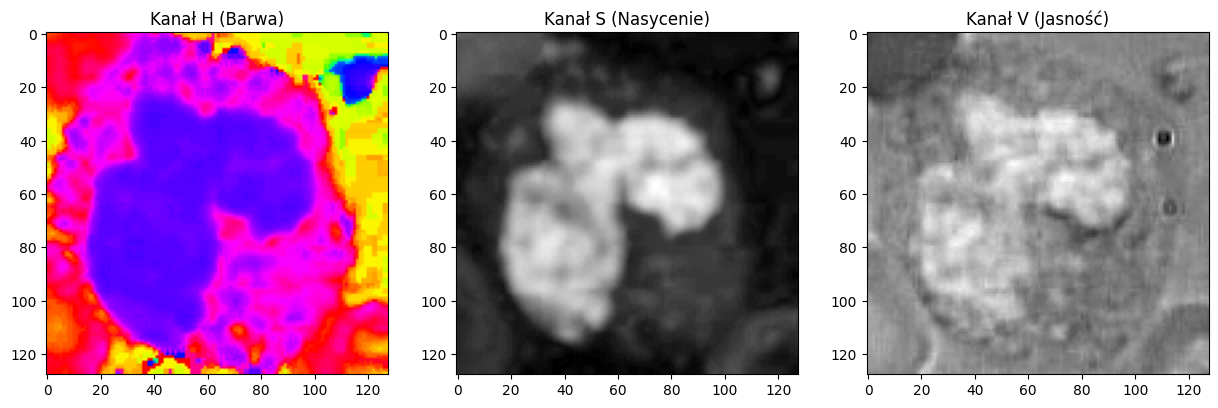

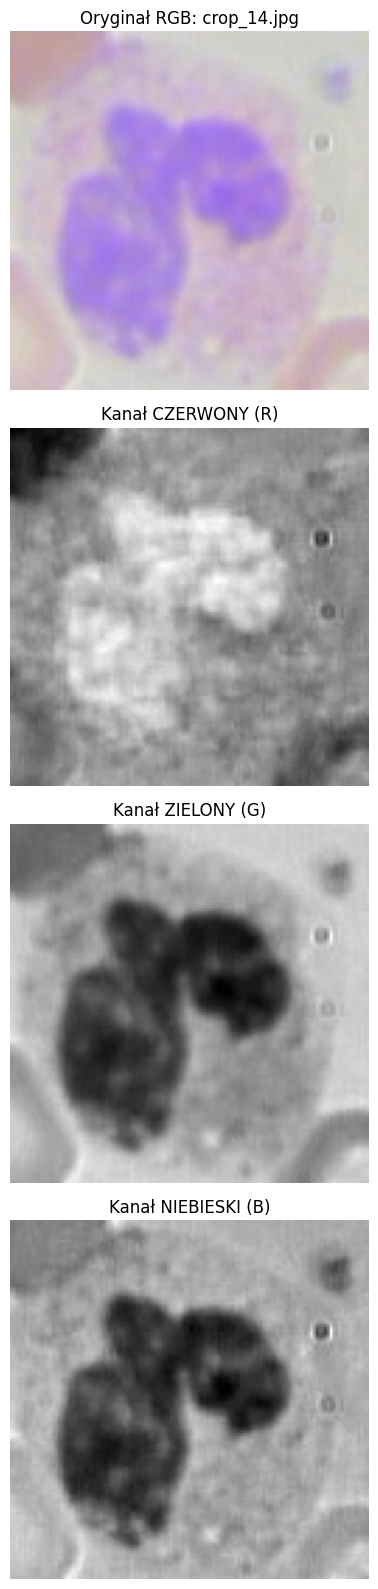

In [9]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt

# Ścieżka do pliku
TEST_FOLDER = os.path.join(BASE_DIR, 'output', 'WBC')
TEST_IMAGE = "crop_14.jpg"
full_path = os.path.join(TEST_FOLDER, TEST_IMAGE)

img = cv.imread(full_path)

if img is None:
    print("Nie znaleziono obrazu!")
else:

    # Konwersja do RGB tylko dla wyświetlenia oryginału
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Konwersja do HSV (Hue Saturation Value)
    img_hsv = cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)
     # Wyświetlenie kanałów osobno
    h, s, v = cv2.split(img_hsv)

    plt.figure(figsize=(15, 5))
    plt.subplot(131); plt.imshow(h, cmap='hsv'); plt.title('Kanał H (Barwa)')
    plt.subplot(132); plt.imshow(s, cmap='gray'); plt.title('Kanał S (Nasycenie)')
    plt.subplot(133); plt.imshow(v, cmap='gray'); plt.title('Kanał V (Jasność)')
    plt.show()

    # Ekstrakcja kanałów z oryginalnego obrazu BGR
    # b = 0, g = 1, r = 2
    b = img_rgb[:, :, 0]
    g = img_rgb[:, :, 1]
    r = img_rgb[:, :, 2]

    # Ustawiamy wyższą figurę, żeby zdjęcia pod sobą nie były spłaszczone
    plt.figure(figsize=(8, 16))

    # 1. Oryginał
    plt.subplot(4, 1, 1)
    plt.title(f"Oryginał RGB: {TEST_IMAGE}")
    plt.imshow(img_rgb)
    plt.axis('off')

    # 2. Kanał CZERWONY
    plt.subplot(4, 1, 2)
    plt.title("Kanał CZERWONY (R)")
    plt.imshow(r, cmap='gray') # Wyświetlamy jako odcienie szarości
    plt.axis('off')

    # 3. Kanał ZIELONY
    plt.subplot(4, 1, 3)
    plt.title("Kanał ZIELONY (G)")
    plt.imshow(g, cmap='gray')
    plt.axis('off')

    # 4. Kanał NIEBIESKI
    plt.subplot(4, 1, 4)
    plt.title("Kanał NIEBIESKI (B)")
    plt.imshow(b, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

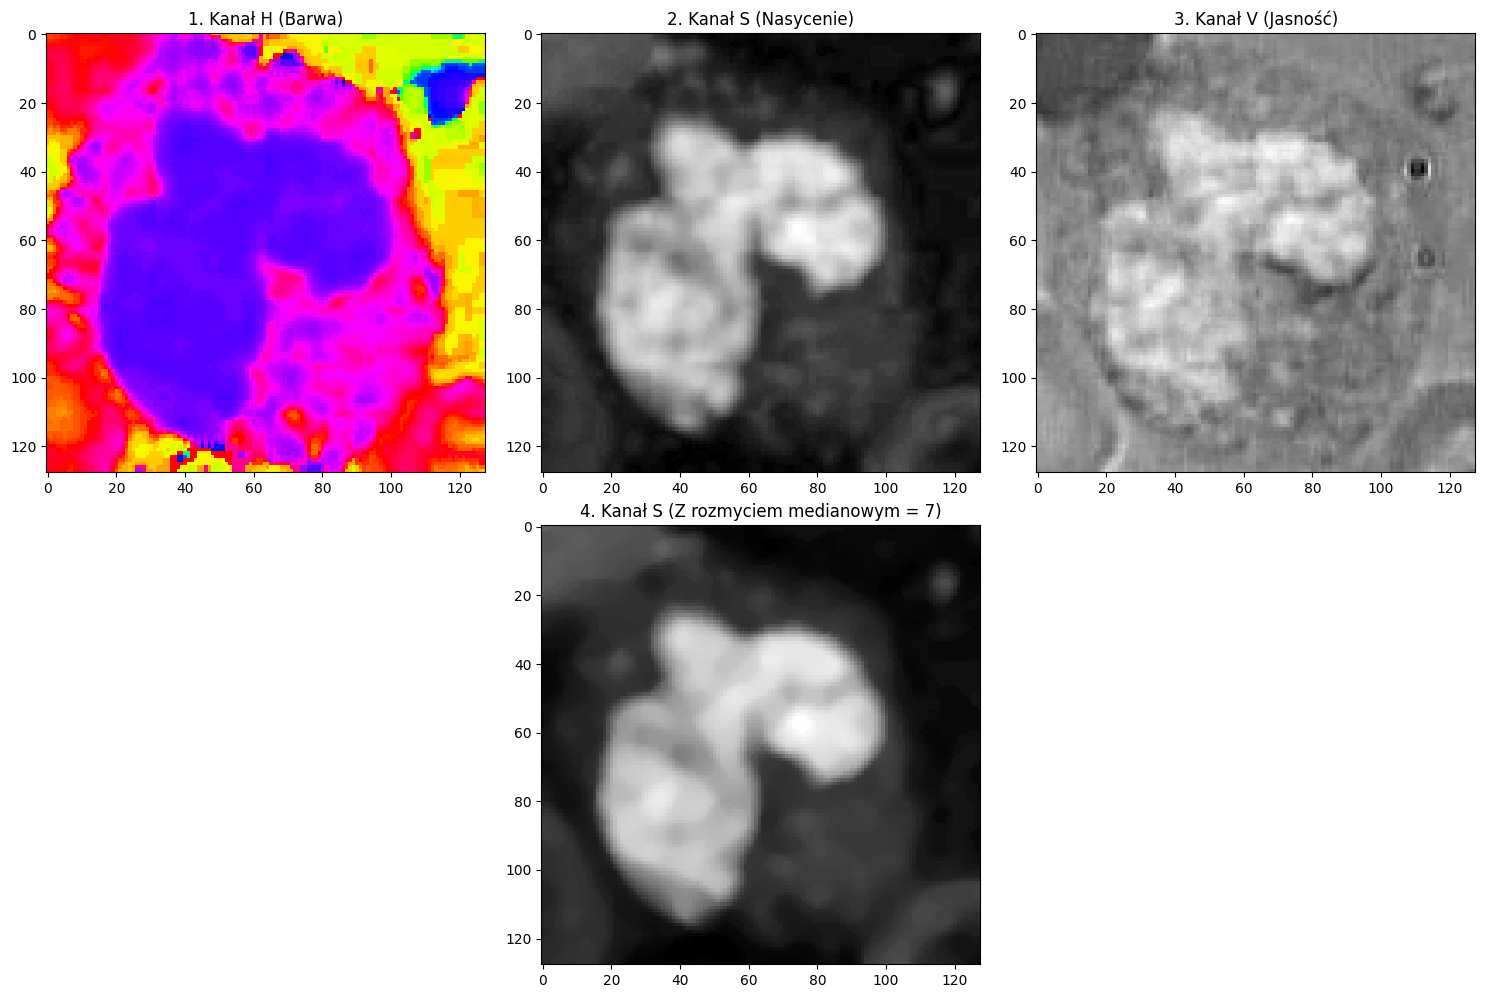

In [10]:
# Konwersja do HSV
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

# Wyświetlenie kanałów osobno
h, s, v = cv2.split(img_hsv)
s_denoised = cv2.medianBlur(s, 7)

plt.figure(figsize=(15, 10))

# Rząd 1
plt.subplot(231); plt.imshow(h, cmap='hsv'); plt.title('1. Kanał H (Barwa)')
plt.subplot(232); plt.imshow(s, cmap='gray'); plt.title('2. Kanał S (Nasycenie)')
plt.subplot(233); plt.imshow(v, cmap='gray'); plt.title('3. Kanał V (Jasność)')

# Rząd 2 - wstawiamy obrazek pod oryginalnym kanałem S
plt.subplot(235); plt.imshow(s_denoised, cmap='gray'); plt.title('4. Kanał S (Z rozmyciem medianowym = 7)')

plt.tight_layout()
plt.show()

Porównano kanały RGB i HSV. Przy porównaniu RGB najlepszy wynik dał kanał zielony i niebieski.
W kanale HSV najlepszy wynik dał kanał nasycenia. Zdecydowano się na wybranie kanału nasycenia ze względu na najlepsze rozróźnienie komórki od otoczenia

#### Nałożenie na wycięte obrazy filtru Saturacji i rozmycia medianowego = 7


##### Przygotowanie folderów


In [14]:
# Stworzenie folderu na wycięte krwinki
output_dir = os.path.join(BASE_DIR, 'output_segmented')

# Słownik, który mapuje ID kategorii na nazwy
kategorie_mapa = {
    1: 'Platelets',
    2: 'RBC',
    3: 'WBC'
}

# Tworzymy foldery, jeśli jeszcze nie istnieją
for nazwa in kategorie_mapa.values():
    os.makedirs(os.path.join(output_dir, nazwa), exist_ok=True)

print("Struktura folderów gotowa w:", output_dir)

Struktura folderów gotowa w: C:\Users\User IKEA\Desktop\BloodCells\output_segmented


##### Zmodyfikowanie obrazów - do nowego folderu

## ⚙️ Metodyka Segmentacji (Pipeline)

W celu stworzenia precyzyjnych masek binarnych zastosowano hybrydowe podejście, dostosowane do specyfiki biologicznej różnych typów krwinek.

### 1. Filtracja i Redukcja Szumu
Zastosowano **filtr medianowy (Median Blur)** z rozmiarem okna `kernel=7`.
* **Cel:** Usunięcie szumu typu "sól i pieprz" (charakterystycznego dla zdjęć mikroskopowych) przy jednoczesnym zachowaniu ostrych krawędzi komórek.

### 2. Dobór Przestrzeni Barw (Kluczowy element)
Analiza histogramów wykazała, że różne krwinki wymagają innej separacji:
* **WBC (Leukocyty) i Płytki:** Wykorzystano **kanał Nasycenia (S)** z modelu HSV. Jądra komórkowe są silnie nasycone (fiolet), co pozwala łatwo oddzielić je od bladego tła.
* **RBC (Erytrocyty):** Wykorzystano **odwrócony Kanał Zielony (G)** z modelu RGB (`255 - G`). Czerwone krwinki silnie pochłaniają zieleń, co daje lepszy kontrast niż nasycenie (które w centrum RBC jest niskie).

### 3. Algorytm K-Means
Do binaryzacji użyto uczenia maszynowego (nienadzorowanego):
* **Algorytm:** K-Means Clustering.
* **Parametr k=2:** Podział pikseli na dwie grupy (Tło vs. Obiekt).
* **Logika:** Algorytm automatycznie znajduje optymalny próg odcięcia dla każdego zdjęcia indywidualnie, co czyni metodę odporną na zmiany oświetlenia.

### 4. Operacje Morfologiczne
Na wygenerowanych maskach wykonano operacje **Closing** (Zamykanie) i **Opening** (Otwarcie), aby:
* Załatać drobne dziury wewnątrz komórek.
* Usunąć pojedyncze artefakty (szum) z tła.

In [21]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans

# 1. Ścieżki i foldery
source_dir = os.path.join(BASE_DIR, 'output')
target_dir = os.path.join(BASE_DIR, 'output_masks')
kategorie = ['Platelets', 'RBC', 'WBC']

for kat in kategorie:
    os.makedirs(os.path.join(target_dir, kat), exist_ok=True)

print("Rozpoczęcie segmentacji...")

for kat in kategorie:
    current_source = os.path.join(source_dir, kat)
    pliki = [f for f in os.listdir(current_source) if f.lower().endswith(('.jpg', '.png'))]
    print(f"Przetwarzanie {kat}: {len(pliki)} plików")

    for nazwa_pliku in pliki:
        img_path = os.path.join(current_source, nazwa_pliku)
        img = cv2.imread(img_path)
        if img is None: continue

        # --- KLUCZOWY FRAGMENT: Wybór kanału ---
        if kat == 'RBC':
            # Dla RBC kanał zielony (indeks 1) daje najlepszy kontrast.
            # Odwracamy go (255 - x), żeby krwinki były jasne na ciemnym tle.
            gray_target = 255 - img[:,:,1]
        else:
            # Dla WBC i Platelets nasycenie (S) z HSV - Najlepszy wynik
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            gray_target = hsv[:,:,1]

        # Filtracja (rozmycie medianowe z parametrem 7 - Najlepszy wynik)
        gray_blur = cv2.medianBlur(gray_target, 7)

        # K-Means
        pixel_values = gray_blur.reshape((-1, 1)).astype(np.float32)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=5) # 2 Klustery, ponieważ klasyfikujemy 2 główne kolory
        labels = kmeans.fit_predict(pixel_values)

        mask = labels.reshape(gray_blur.shape)

        # Upewnienie się, że obiekt jest biały (255)
        if np.mean(gray_blur[mask == 1]) < np.mean(gray_blur[mask == 0]):
            mask = 1 - mask

        mask_uint8 = (mask * 255).astype(np.uint8)

        # Zapis
        cv2.imwrite(os.path.join(target_dir, kat, nazwa_pliku), mask_uint8)

print("Zakończono")

Rozpoczęcie segmentacji...
Przetwarzanie Platelets: 249 plików
Przetwarzanie RBC: 2936 plików
Przetwarzanie WBC: 263 plików
Zakończono


## 📤 Wyniki i Przekazanie Prac

**Status:** Zakończono generowanie masek.

**Struktura danych wyjściowych:**
Pliki zostały zapisane w folderze `output_masks/` z podziałem na kategorie (`WBC`, `RBC`, `Platelets`).

**Format plików:**
* Obrazy binarne (czarno-białe).
* **Wartość 0 (Czarny):** Tło.
* **Wartość 255 (Biały):** Obszar komórki (ROI - Region of Interest).

**Uwagi dla Osoby 2 (Ekstrakcja Cech):**
* Maski są gotowe do obliczeń geometrycznych (Pole powierzchni, Obwód, Współczynniki kształtu).
* W przypadku RBC maski mogą posiadać naturalne wgłębienia (zgodne z fizjologią krwinki), co należy uwzględnić przy analizie topologii.

#### /// Testy RBC

In [19]:
import cv2
import numpy as np
import os

# Parametry poprawy masek
# Kernel (5,5) to dobry złoty środek. Jeśli dziury zostają, spróbuj (7,7)
kernel = np.ones((7, 7), np.uint8)

print("Rozpoczynam poprawianie masek (operacje morfologiczne)...")

for kat in ['Platelets', 'RBC', 'WBC']:
    mask_folder = os.path.join(target_dir, kat)
    pliki = [f for f in os.listdir(mask_folder) if f.lower().endswith(('.jpg', '.png'))]

    for nazwa_pliku in pliki:
        path = os.path.join(mask_folder, nazwa_pliku)
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if mask is None: continue

        # 1. Closing - zalepia dziury wewnątrz krwinek
        refined_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 2. Opening - usuwa małe białe kropki (szum) z tła
        refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)

        # Zapisujemy poprawioną maskę
        cv2.imwrite(path, refined_mask)

print("Sukces! Maski zostały wygładzone i dziury załatane.")

Rozpoczynam poprawianie masek (operacje morfologiczne)...
Sukces! Maski zostały wygładzone i dziury załatane.
